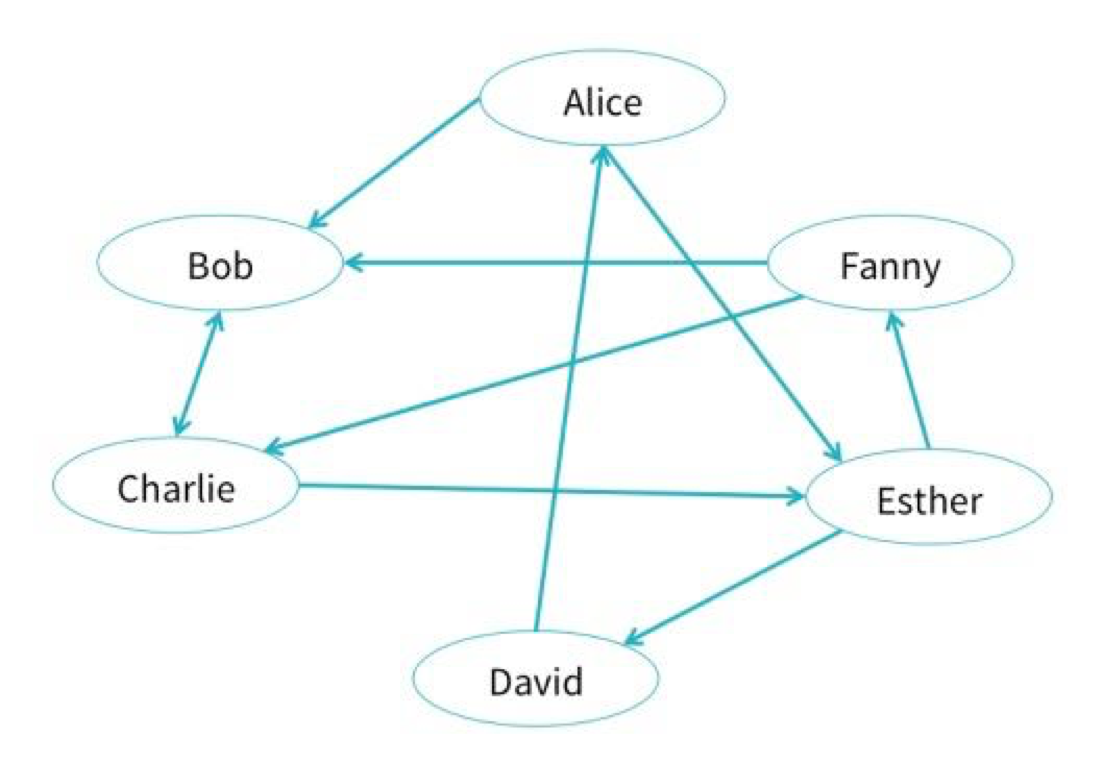

In [68]:
from IPython.display import display, Image
Image(filename='../Network.png',width=500, height = 200)

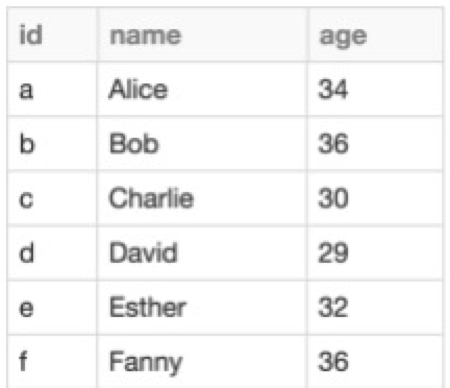

In [70]:
Image(filename='../Users.png',width=250, height = 100)

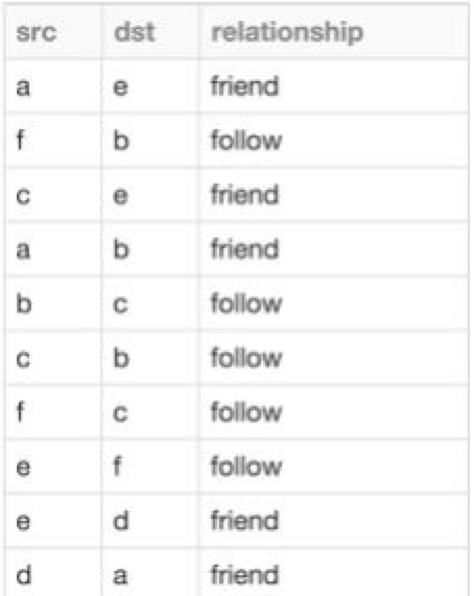

In [76]:
Image(filename='../relationship.png',width=300)

In [ ]:
#$pyspark --packages graphframes:graphframes:0.5.0-spark2.1-s_2.11

import pyspark
pyspark.__version__



# SparkContext( ) 
# main entry point for Spark functionality. 
# A SparkContext represents the connection to a Spark cluster, 
# and can be used to create RDDs, accumulators and broadcast variables on that cluster.
from pyspark import SparkContext, SparkConf
#sc = SparkContext()


# SQLContext/HiveContext
# Entry point for all SQL functionality
# Wraps/extends existing spark context
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

#### GraphFrames Tutorial
# Create a Vertex DataFrame with unique ID column "id"
v = sqlContext.createDataFrame([
    ("a", "Alice", 34),
    ("b", "Bob", 36),
    ("c", "Charlie", 30),
    ("d", "David", 29),
    ("e", "Esther", 32),
    ("f", "Fanny", 36)], 
    ["id", "name", "age"])

# Create an Edge DataFrame with "src" and "dst" columns
e = sqlContext.createDataFrame([
    ("a", "e", "friend"),
    ("f", "b", "follow"),
    ("c", "e", "friend"),
    ("a", "b", "friend"),
    ("b", "c", "follow"),
    ("c", "b", "follow"),
    ("f", "c", "follow"),
    ("e", "f", "follow"),
    ("e", "d", "friend"),
    ("d", "a", "friend")], 
    ["src", "dst", "relationship"])

# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)
print(g)

print(g)
GraphFrame(v:[id: string, name: string ... 1 more field], e:[src: string, dst: string ... 1 more field])

In [ ]:
# Display the vertex and edge DataFrames
g.vertices.show()

In [ ]:
g.vertices.show()
+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+

In [ ]:
g.edges.show()

In [ ]:
g.edges.show()
+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  e|      friend|
|  f|  b|      follow|
|  c|  e|      friend|
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+

In [ ]:
#find out uses older than 35
g.vertices.filter("age > 35").show()

In [ ]:
g.vertices.filter("age > 35").show()
+---+-----+---+
| id| name|age|
+---+-----+---+
|  b|  Bob| 36|
|  f|Fanny| 36|
+---+-----+---+

In [ ]:
# save into temp Dataframe
temp = g.vertices.filter("age > 35")

temp = g.vertices.filter("age > 35")
temp
DataFrame[id: string, name: string, age: bigint]

In [ ]:
# Query: Get in-degree of each vertex.
g.inDegrees.show()

In [ ]:
g.inDegrees.show()
+---+--------+
| id|inDegree|
+---+--------+
|  f|       1|
|  e|       2|
|  d|       1|
|  c|       2|
|  b|       3|
|  a|       1|
+---+--------+

In [ ]:
g.inDegrees.filter("inDegree >= 2")

In [ ]:
g.outDegrees.show()

In [ ]:
g.outDegrees.show()
+---+---------+
| id|outDegree|
+---+---------+
|  f|        2|
|  e|        2|
|  d|        1|
|  c|        2|
|  b|        1|
|  a|        2|
+---+---------+

In [ ]:
g.outDegrees.filter("outDegree >= 2")

In [ ]:
g.degrees.show()

In [ ]:
g.degrees.show()
+---+------+
| id|degree|
+---+------+
|  f|     3|
|  e|     4|
|  d|     2|
|  c|     4|
|  b|     4|
|  a|     3|
+---+------+

In [ ]:
# Query: Count the number of "follow" connections in the graph.
# This queries the edge DataFrame.
g.edges.filter("relationship = 'follow'").count()

g.edges.filter("relationship = 'follow'").count()
5

### Motif finding

Motif finding refers to searching for structural patterns in a graph.

GraphFrame motif finding uses a simple Domain-Specific Language (DSL) for expressing structural queries. For example, graph.find("(a)-[e]->(b); (b)-[e2]->(a)") will search for pairs of vertices a,b connected by edges in both directions. It will return a DataFrame of all such structures in the graph, with columns for each of the named elements (vertices or edges) in the motif. In this case, the returned columns will be “a, b, e, e2.”

"(a)-[e]->(b)" expresses an edge e from vertex a to vertex b. Note that vertices are denoted by parentheses (a), while edges are denoted by square brackets [e].

It is acceptable to omit names for vertices or edges in motifs when not needed. E.g., "(a)-[]->(b)" expresses an edge between vertices a,b but does not assign a name to the edge. There will be no column for the anonymous edge in the result DataFrame. Similarly, "(a)-[e]->()" indicates an out-edge of vertex a but does not name the destination vertex.
An edge can be negated to indicate that the edge should not be present in the graph. E.g., "(a)-[]->(b); !(b)-[]->(a)" finds edges from a to b for which there is no edge from b to a.

In [ ]:
# Search for pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

In [ ]:
motifs.show()
+--------------+------------+--------------+------------+
|             a|           e|             b|          e2|
+--------------+------------+--------------+------------+
|[c,Charlie,30]|[c,b,follow]|    [b,Bob,36]|[b,c,follow]|
|    [b,Bob,36]|[b,c,follow]|[c,Charlie,30]|[c,b,follow]|
+--------------+------------+--------------+------------+

In [ ]:
 motifs.filter("b.age > 30").show()
+--------------+------------+----------+------------+
|             a|           e|         b|          e2|
+--------------+------------+----------+------------+
|[c,Charlie,30]|[c,b,follow]|[b,Bob,36]|[b,c,follow]|
+--------------+------------+----------+------------+

In [ ]:
# find pattern
# Motif: A->B->C but not A->C
results = g.find("(A)-[]->(B); (B)-[]->(C); !(A)-[]->(C)")

In [ ]:
results.show()
+--------------+--------------+--------------+
|             A|             B|             C|
+--------------+--------------+--------------+
| [e,Esther,32]|  [f,Fanny,36]|[c,Charlie,30]|
| [e,Esther,32]|  [d,David,29]|  [a,Alice,34]|
|[c,Charlie,30]| [e,Esther,32]|  [f,Fanny,36]|
|  [d,David,29]|  [a,Alice,34]|    [b,Bob,36]|
|[c,Charlie,30]|    [b,Bob,36]|[c,Charlie,30]|
|  [a,Alice,34]| [e,Esther,32]|  [d,David,29]|
|[c,Charlie,30]| [e,Esther,32]|  [d,David,29]|
|  [d,David,29]|  [a,Alice,34]| [e,Esther,32]|
|  [f,Fanny,36]|[c,Charlie,30]| [e,Esther,32]|
|    [b,Bob,36]|[c,Charlie,30]|    [b,Bob,36]|
|  [a,Alice,34]| [e,Esther,32]|  [f,Fanny,36]|
| [e,Esther,32]|  [f,Fanny,36]|    [b,Bob,36]|
|  [a,Alice,34]|    [b,Bob,36]|[c,Charlie,30]|
|    [b,Bob,36]|[c,Charlie,30]| [e,Esther,32]|
+--------------+--------------+--------------+

In [ ]:
results = g.find("(A)-[]->(B); (B)-[]->(A)")
results.show()
+--------------+--------------+
|             A|             B|
+--------------+--------------+
|[c,Charlie,30]|    [b,Bob,36]|
|    [b,Bob,36]|[c,Charlie,30]|
+--------------+--------------+

results = g.find("(A)-[AB]->(B); (B)-[BA]->(A)")
results.show()
+--------------+------------+--------------+------------+
|             A|          AB|             B|          BA|
+--------------+------------+--------------+------------+
|[c,Charlie,30]|[c,b,follow]|    [b,Bob,36]|[b,c,follow]|
|    [b,Bob,36]|[b,c,follow]|[c,Charlie,30]|[c,b,follow]|
+--------------+------------+--------------+------------+

### sub-graph

In [ ]:
v2 = g.vertices.filter("age > 30")
e2 = g.edges.filter("relationship = 'friend'")
g2 = GraphFrame(v2, e2)

In [ ]:
g2.edges.show()
+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  e|      friend|
|  c|  e|      friend|
|  a|  b|      friend|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+

In [56]:
#### Selemct a subgraph based upon triplet filters which operate on an edge and its src and dst vertices. 

In [ ]:
# Select subgraph based on edges "e" of type "follow"
# pointing from a younger user "a" to an older user "b".
paths = g.find("(a)-[e]->(b)")\
  .filter("e.relationship = 'follow'")\
  .filter("a.age < b.age") # a's age <b's age

In [ ]:
paths.show()
+--------------+------------+------------+
|             a|           e|           b|
+--------------+------------+------------+
| [e,Esther,32]|[e,f,follow]|[f,Fanny,36]|
|[c,Charlie,30]|[c,b,follow]|  [b,Bob,36]|
+--------------+------------+------------+

In [ ]:
# "paths" contains vertex info. Extract the edges.
e2 = paths.select("e.src", "e.dst", "e.relationship")

In [ ]:
e2 = paths.select("e.src", "e.dst", "e.relationship")
e2
DataFrame[src: string, dst: string, relationship: string]
>>> e2.show()
+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  e|  f|      follow|
|  c|  b|      follow|
+---+---+------------+


In [ ]:
# Construct the subgraph
g2 = GraphFrame(g.vertices, e2)

### Breadth-first search (BFS)

Breadth-first search (BFS) finds the shortest path(s) from one vertex (or a set of vertices) to another vertex (or a set of vertices). The beginning and end vertices are specified as Spark DataFrame expressions.

In [ ]:
# Search from "Esther" for users of age < 32.
paths = g.bfs("name = 'Esther'", "age < 32")
paths.show()

In [ ]:
paths.show()
+-------------+------------+------------+
|         from|          e0|          to|
+-------------+------------+------------+
|[e,Esther,32]|[e,d,friend]|[d,David,29]|
+-------------+------------+------------+

In [ ]:
# Specify edge filters or max path lengths.
g.bfs("name = 'Esther'", "age < 32",\
  edgeFilter="relationship != 'friend'", maxPathLength=3)

In [ ]:
g.bfs("name = 'Esther'", "age < 32",\
...   edgeFilter="relationship != 'friend'", maxPathLength=3).show()
+-------------+------------+------------+------------+--------------+
|         from|          e0|          v1|          e1|            to|
+-------------+------------+------------+------------+--------------+
|[e,Esther,32]|[e,f,follow]|[f,Fanny,36]|[f,c,follow]|[c,Charlie,30]|
+-------------+------------+------------+------------+--------------+

### Connected components

In graph theory, a connected component (or just component) of an undirected graph is a subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the supergraph. 

In [ ]:
result = g.connectedComponents()
result.select("id", "component").orderBy("component").show()

### PageRank



In [ ]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.01, maxIter=20)
print results;

results.vertices.select("id", "pagerank").show()
results.vertices.show()

In [ ]:
#Graph IO
# Save vertices and edges as Parquet to some location.
g.vertices.write.parquet("hdfs://myLocation/vertices")
g.edges.write.parquet("hdfs://myLocation/edges")

# Load the vertices and edges back.
sameV = sqlContext.read.parquet("hdfs://myLocation/vertices")
sameE = sqlContext.read.parquet("hdfs://myLocation/edges")

# Create an identical GraphFrame.
sameG = GraphFrame(sameV, sameE)


